# ABA: Quiz 2 Solutions

### Spring 2024

# Question 1

### 1.	Many disease-free individuals were enrolled in a study beginning January 1, 1970, and were followed for 30 years to assess the age at which they developed breast cancer. Individuals had clinical exams every 3 years after enrollment. For the selected individuals described below, discuss in detail, the type of censoring is represented (if any). [5]

#### (a) A healthy individual, enrolled in the study at age 30, did not develop breast cancer during the study.

**Right censoring**. Right censoring occurs when the study ends before the event (in this case, the development of breast cancer) has occurred, or the individual does not experience the event before the end of the study period. Since the individual enrolled at age 30 did not develop breast cancer during the 30-year study, we do not know if or when they might develop it after the study ends.

#### (b) A healthy individual, enrolled in the study at age 40, was diagnosed with breast cancer at the fifth exam after enrollment (i.e., the disease started sometime between 12 and 15 years after enrollment).

**Not censored**. Individual developed breast cancer during the study period. The time of diagnosis is known (between 12 and 15 years after enrollment), within the period of study.

#### (c) An individual, enrolled in the study at age 42, moved away from the community at age 55 and was never diagnosed with breast cancer during the period of observation.

**Right censoring**. Since they left the study before its completion and before developing breast cancer, we lack complete information about their time to event (i.e., the time to develop breast cancer). We know that they did not develop breast cancer until age 55, but we don't know what happened after they moved away.

# Question 2

In [3]:
# Import required libraries :
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

### 2. A Cruize is interested in understanding its customers’ repeat visit to the cruise. The firm surveys its customers and collects the following data. 

In [6]:
data = pd.read_excel('cruize_visit.xlsx')
data.rename(columns={'Take Cruize Again':'take_cruise_again','Promotion type':'promo_type'},inplace=True)
data.head()

,Time,take_cruise_again,promo_type,Age
0,1,1,1,66
1,1,1,1,38
2,2,1,1,54
3,3,1,1,57
4,3,1,1,75


### Using python, can you plot survival probability? Comment on the confidence interval? [7]

Survival probability is given by:
    
$$S_{t+1} = S_t \times \left(1 - \frac{D_{t+1}}{N_{t+1}}\right)$$

- $ S_{t+1}$: The survival probability at time \( t+1 \).
- $ S_t $: The survival probability at time \( t \), which is the probability of surviving up to just before time \( t+1 \).
- $ D_{t+1}$: The number of events (in this case, going on a cruise) that happened at time \( t+1 \).
- $ N_{t+1}$: The number of individuals at risk of the event at time \( t+1 \), just before the event could occur.



We'll show how to compute the survival probability "manually" and how to use the lifeline package:

### "Manual" calculations

In [7]:
num_obs = len(data)
print("Num Obs:", num_obs)
df_summary = data.groupby('Time').agg(
    events=('take_cruise_again', lambda x: (x == 1).sum()),  # if customer has taken cruise
    censored=('take_cruise_again', lambda x: (x == 0).sum())   # if customer has NOT taken cruise
).reset_index()
df_summary.head()

Num Obs: 47


,Time,events,censored
0,1,2,0
1,2,3,0
2,3,2,0
3,4,2,0
4,5,2,0


In [8]:
#ADD TIME ZERO
# Add a row with Time 0 and events 0 at the beginning
new_row = pd.DataFrame({'Time': [0], 'events': [0],'censored':[0]})
df_summary = pd.concat([new_row, df_summary], ignore_index=True)

#initialize at_risk and surv probability
df_summary['at_risk'] = num_obs 
df_summary['surv'] = 1
df_summary.head()

,Time,events,censored,at_risk,surv
0,0,0,0,47,1
1,1,2,0,47,1
2,2,3,0,47,1
3,3,2,0,47,1
4,4,2,0,47,1


In [9]:
#compute risk and survival probability
tot_time = len(df_summary)
for i in range(1,tot_time):
    #set number of participants at risk
    total_removed = df_summary.iloc[i-1].events + df_summary.iloc[i-1].censored
    df_summary.loc[i,'at_risk'] = df_summary.iloc[i-1]['at_risk'] - total_removed
    if i>0:
        #compute survival
        df_summary.loc[i,'surv'] = df_summary.iloc[i-1].surv*(1-df_summary.iloc[i].events/df_summary.iloc[i].at_risk)
df_summary

,Time,events,censored,at_risk,surv
0,0,0,0,47,1.000000
1,1,2,0,47,0.957447
2,2,3,0,45,0.893617
3,3,2,0,42,0.851064
4,4,2,0,40,0.808511
5,5,2,0,38,0.765957
6,6,3,1,36,0.702128
7,8,3,0,32,0.636303
8,9,0,1,29,0.636303
9,10,1,1,28,0.613578


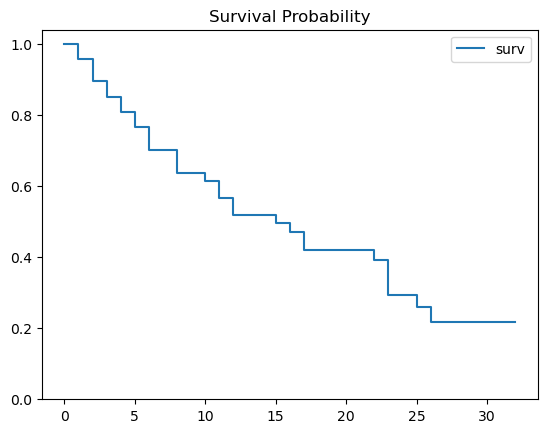

In [10]:
#Plot survival curve
plt.step(data=df_summary,x='Time',y='surv',where='post')
plt.ylim(0,None)
plt.title("Survival Probability")
plt.legend()
plt.show()

Now, we generate 95 percent confidence intervals

In [11]:
df_summary['aux_1'] = 0
df_summary['aux_2'] = 0

In [12]:
df_summary
for i in range(1,tot_time):
    if i>0:
        #compute survival
        df_summary.loc[i,'aux_1'] = df_summary.iloc[i].events/(df_summary.iloc[i].at_risk*(df_summary.iloc[i].at_risk-df_summary.iloc[i].events))
df_summary['aux_2'] = df_summary.aux_1.cumsum()
df_summary['se'] = df_summary.surv*np.sqrt(df_summary['aux_2'])
df_summary['ci_lower'] = df_summary.surv - 1.96*df_summary['se']
df_summary['ci_upper'] = df_summary.surv + 1.96*df_summary['se']
df_summary

,Time,events,censored,at_risk,surv,aux_1,aux_2,se,ci_lower,ci_upper
0,0,0,0,47,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
1,1,2,0,47,0.957447,0.000946,0.000946,0.029442,0.899740,1.015154
2,2,3,0,45,0.893617,0.001587,0.002533,0.044974,0.805468,0.981766
3,3,2,0,42,0.851064,0.001190,0.003723,0.051932,0.749278,0.952850
4,4,2,0,40,0.808511,0.001316,0.005039,0.057394,0.696018,0.921003
5,5,2,0,38,0.765957,0.001462,0.006501,0.061759,0.644910,0.887005
6,6,3,1,36,0.702128,0.002525,0.009026,0.066707,0.571381,0.832874
7,8,3,0,32,0.636303,0.003233,0.012259,0.070452,0.498217,0.774390
8,9,0,1,29,0.636303,0.000000,0.012259,0.070452,0.498217,0.774390
9,10,1,1,28,0.613578,0.001323,0.013582,0.071507,0.473424,0.753733


### Using Lifelines package

In [13]:
data.head()

,Time,take_cruise_again,promo_type,Age
0,1,1,1,66
1,1,1,1,38
2,2,1,1,54
3,3,1,1,57
4,3,1,1,75


In [38]:
# data = data.rename(columns={'take_cruise_again':'events', 'promo_type':'treatment'})
# data['treatment'] = np.random.choice([0,1], size=len(data))

In [39]:
# data

,Time,events,treatment,Age
0,1,1,1,66
1,1,1,0,38
2,2,1,0,54
3,3,1,1,57
4,3,1,1,75
5,4,1,1,30
6,4,1,1,49
7,5,1,0,75
8,5,1,0,71
9,6,1,1,50


In [14]:
# Create the object for our method :
kmf = KaplanMeierFitter() 

# we want to fit the duration when the event is "goes on cruise"
kmf.fit(durations =  data["Time"], event_observed = data["take_cruise_again"])

kmf.event_table

# Removed = Observed + Censored
# Censored = Person that didn't go on cruise.
# Observed = Persons that goes on cruise.

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,47,47
1.0,2,2,0,0,47
2.0,3,3,0,0,45
3.0,2,2,0,0,42
4.0,2,2,0,0,40
5.0,2,2,0,0,38
6.0,4,3,1,0,36
8.0,3,3,0,0,32
9.0,1,0,1,0,29


In [15]:
# Survival probability :
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.957447
2.0,0.893617
3.0,0.851064
4.0,0.808511
5.0,0.765957
6.0,0.702128
8.0,0.636303
9.0,0.636303


In [16]:
# provides the number of periods where on average 50% of patients go on cruise.
kmf.median_survival_time_

15.0

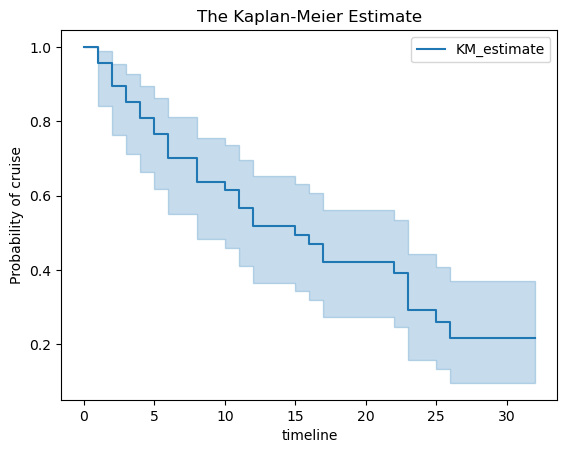

In [17]:
# Plot the graph :

kmf.plot()
plt.title("The Kaplan-Meier Estimate")
plt.ylabel("Probability of cruise")
plt.show()

We can also inspect the confidence interval using kmf.confidence_interval_  

In [18]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
1.0,0.840388,0.989185
2.0,0.763107,0.954283
3.0,0.712804,0.926056
4.0,0.664296,0.895420
5.0,0.617364,0.862948
6.0,0.549501,0.811499
8.0,0.481614,0.755986
9.0,0.481614,0.755986
10.0,0.458557,0.736385


We observe that the CI starts realtively narrow (low uncertainty), and widens as time progresses (higher uncertainty).

### You want to compare whether promotion types make a difference in survival probability? First plot survival curves for promotion type and then do a long rank test to compare promotion types. Show the calculation by hand. [13]

#### Promotion 1

In [19]:
#promotion mask
promo_mask = data.promo_type == 1

num_obs = len(data[promo_mask])
print("Num Obs:", num_obs)
df_promo1 = data[promo_mask].groupby('Time').agg(
    events=('take_cruise_again', lambda x: (x == 1).sum()),  # if customer has taken cruise
    censored=('take_cruise_again', lambda x: (x == 0).sum())   # if customer has NOT taken cruise
).reset_index()


#ADD TIME ZERO
# Add a row with Time 0 and events 0 at the beginning
new_row = pd.DataFrame({'Time': [0], 'events': [0],'censored':[0]})
df_promo1 = pd.concat([new_row, df_promo1], ignore_index=True)

#initialize at_risk and surv probability
df_promo1['at_risk'] = num_obs 
df_promo1['surv'] = 1
df_promo1.head()

#compute risk and survival probability
tot_time = len(df_promo1)
for i in range(1,tot_time):
    #set number of participants at risk
    total_removed = df_promo1.iloc[i-1].events + df_promo1.iloc[i-1].censored
    df_promo1.loc[i,'at_risk'] = df_promo1.iloc[i-1]['at_risk'] - total_removed
    if i>0:
        #compute survival
        df_promo1.loc[i,'surv'] = df_promo1.iloc[i-1].surv*(1-df_promo1.iloc[i].events/df_promo1.iloc[i].at_risk)
df_promo1

Num Obs: 22


,Time,events,censored,at_risk,surv
0,0,0,0,22,1.000000
1,1,2,0,22,0.909091
2,2,1,0,20,0.863636
3,3,2,0,19,0.772727
4,4,2,0,17,0.681818
5,5,2,0,15,0.590909
6,6,1,0,13,0.545455
7,8,3,0,12,0.409091
8,11,2,0,9,0.318182
9,12,2,0,7,0.227273


#### Promotion 2

In [20]:
#promotion mask
promo_mask = data.promo_type == 2

num_obs = len(data[promo_mask])
print("Num Obs:", num_obs)
df_promo2 = data[promo_mask].groupby('Time').agg(
    events=('take_cruise_again', lambda x: (x == 1).sum()),  # if customer has taken cruise
    censored=('take_cruise_again', lambda x: (x == 0).sum())   # if customer has NOT taken cruise
).reset_index()


#ADD TIME ZERO
# Add a row with Time 0 and events 0 at the beginning
new_row = pd.DataFrame({'Time': [0], 'events': [0],'censored':[0]})
df_promo2 = pd.concat([new_row, df_promo2], ignore_index=True)

#initialize at_risk and surv probability
df_promo2['at_risk'] = num_obs 
df_promo2['surv'] = 1
df_promo2.head()

#compute risk and survival probability
tot_time = len(df_promo2)
for i in range(1,tot_time):
    #set number of participants at risk
    total_removed = df_promo2.iloc[i-1].events + df_promo2.iloc[i-1].censored
    df_promo2.loc[i,'at_risk'] = df_promo2.iloc[i-1]['at_risk'] - total_removed
    if i>0:
        #compute survival
        df_promo2.loc[i,'surv'] = df_promo2.iloc[i-1].surv*(1-df_promo2.iloc[i].events/df_promo2.iloc[i].at_risk)
df_promo2

Num Obs: 25


,Time,events,censored,at_risk,surv
0,0,0,0,25,1.000000
1,2,2,0,25,0.920000
2,6,2,1,23,0.840000
3,9,0,1,20,0.840000
4,10,1,1,19,0.795789
5,14,0,1,17,0.795789
6,15,1,0,16,0.746053
7,16,1,0,15,0.696316
8,18,0,1,14,0.696316
9,19,0,1,13,0.696316


In [21]:
df_promo1.to_csv('promo_1.csv')
df_promo2.to_csv('promo_2.csv')

#manual calculations, see excel file cruise_promo_solved
df_promo1.merge(df_promo2,how='outer',on='Time')
df_promo1.merge(df_promo2,how='outer',on='Time').to_csv('promo_both.csv')

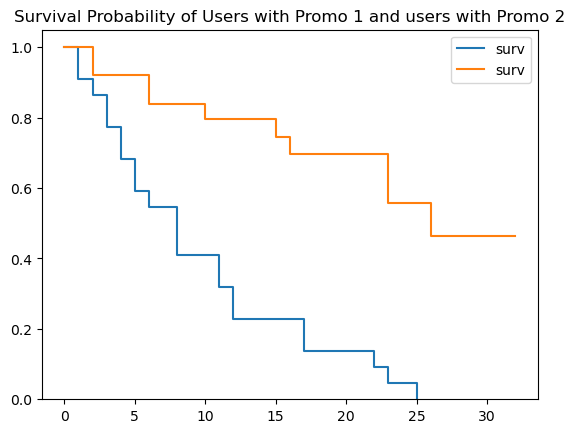

In [22]:
#plot
plt.step(data=df_promo1,x='Time',y='surv',where='post')
plt.step(data=df_promo2,x='Time',y='surv',where='post')
plt.title("Survival Probability of Users with Promo 1 and users with Promo 2")
plt.ylim(0,None)
plt.legend()
plt.show()

### Using Lifelines 

In [25]:
kmf1.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.909091
2.0,0.863636
3.0,0.772727
4.0,0.681818
5.0,0.590909
6.0,0.545455
8.0,0.409091
11.0,0.318182


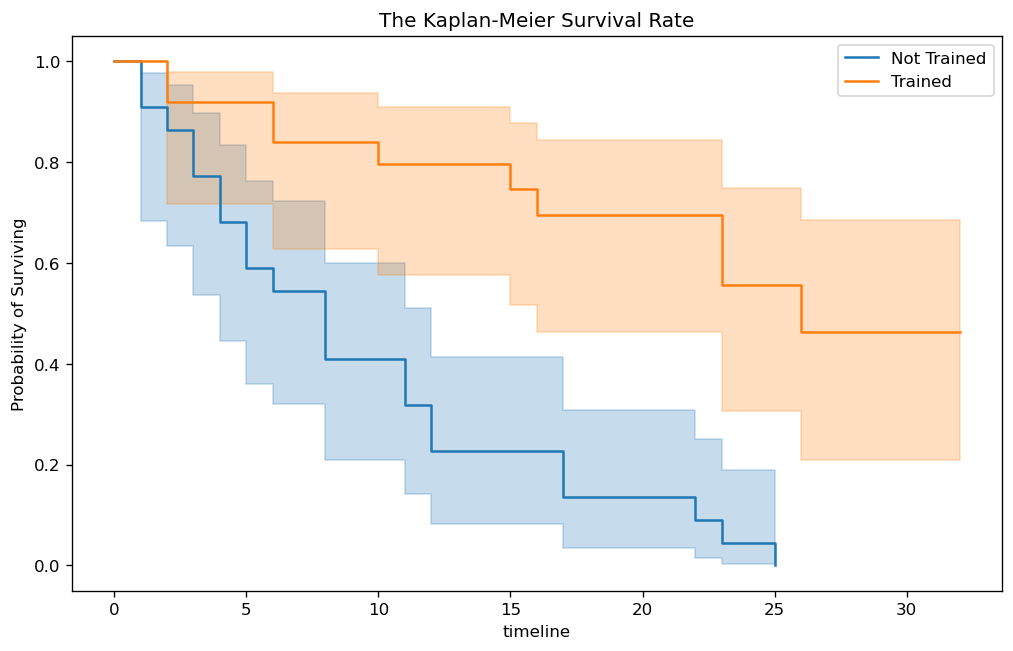

In [35]:
# Create the object for our method :
kmf1 = KaplanMeierFitter() 
kmf2 = KaplanMeierFitter() 

# fit
df_p1 = data[data.promo_type == 1].reset_index(drop=True)
df_p2 = data[data.promo_type == 2].reset_index(drop=True)
kmf1.fit(durations =  df_p1["Time"], event_observed = df_p1["take_cruise_again"])
kmf2.fit(durations =  df_p2["Time"], event_observed = df_p2["take_cruise_again"])

# Plot the graph :
plt.figure(figsize=(10,6), dpi=120)
kmf1.plot(label = 'Not Trained')
kmf2.plot(label = 'Trained')
plt.title("The Kaplan-Meier Survival Rate")
plt.ylabel("Probability of Surviving")
plt.show()

Compute log rank statistic using lifelines

In [32]:
from lifelines.statistics import logrank_test

df_p1 = data[data.promo_type==1].reset_index(drop=True)
df_p2 = data[data.promo_type==2].reset_index(drop=True)

results=logrank_test(df_p1.Time,df_p2.Time,event_observed_A=df_p1.take_cruise_again, event_observed_B=df_p2.take_cruise_again)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          21.07 <0.005     17.79

Log rank test is simply testing if two groups are different. It is a chi square test and since one is comparing 2 groups, it is a chi square test with degree 1. In this case, we have evidence that the two groups survival probability is different.